In [3]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0
%env DETECTRON2_DATASETS ./data/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0
env: DETECTRON2_DATASETS=./data/


In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path
from typing import Sequence

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Result Plotting

In [18]:
codec = 'vvenc'

base_result = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result.csv')
filter_result = pd.read_csv(saved_filter_model_path / 'result.csv')

base_result = base_result[base_result['codec'] == codec]
filter_result = filter_result[filter_result['codec'] == codec]

In [ ]:
plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=filter_result['bpp'], y=filter_result['metric'], label=saved_filter_model_path.parent.name)
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.savefig('result.png', dpi=300)
plt.show()

In [ ]:
# Post Filtering Results

codec = 'vvenc'
# out2/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s100000_bs1_adam_lr0.0001_constant
saved_filter_model_path_1 = Path('out2/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s100000_bs1_adam_lr0.0001_constant')
saved_filter_model_path_2 = Path('out2/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s100000_bs1_adam_lr0.0001_constantv')
saved_filter_model_path_3 = Path('result_q8_ld1.0_50k.csv')

base_result = pd.read_csv('result_baseline.csv')
filter_result_1 = pd.read_csv('out2/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s100000_bs1_adam_lr0.0001_constant/result_q8_ld1.0_50k_pf.csv')
filter_result_2 = pd.read_csv('out2/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s100000_bs1_adam_lr0.0001_constant/result_q8_ld1.0_100k_pf.csv')

base_result = base_result[base_result['codec'] == codec]
filter_result_1 = filter_result_1[filter_result_1['codec'] == codec]
filter_result_2 = filter_result_2[filter_result_2['codec'] == codec]
filter_result_3 = filter_result_3[filter_result_3['quality'] >= 40]

plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=filter_result_1['bpp'], y=filter_result_1['metric'], label=saved_filter_model_path_1.parent.name+'_w/ pf')
plt.scatter(x=filter_result_2['bpp'], y=filter_result_2['metric'], label=saved_filter_model_path_2.parent.name+'_w/ pf')
plt.scatter(x=filter_result_3['bpp'], y=filter_result_3['metric'], label=saved_filter_model_path_3.name[7:15]+'_w/o pf')


plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.savefig('result.png', dpi=300)
plt.show()

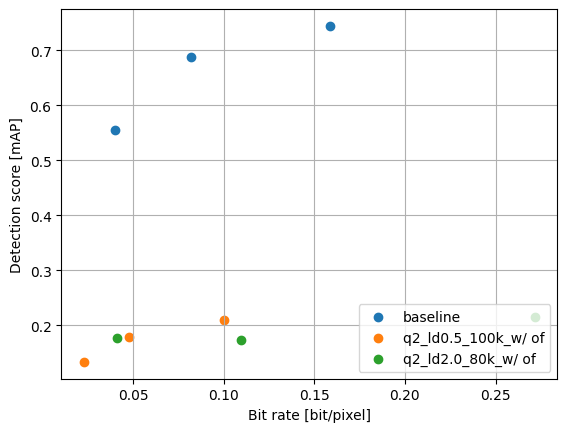

In [7]:
# Post Filtering Results
# without surrogate encoder (only filter)

codec = 'vvenc'
saved_filter_model_path_1 = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld0.5/s100000_bs1_adam_lr0.0001_exponential_0.1')
saved_filter_model_path_2 = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld2.0/s100000_bs1_adam_lr0.0001_exponential_0.1')
saved_filter_model_path_3 = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld4.0/s100000_bs1_adam_lr0.0001_exponential_0.1')

base_result = pd.read_csv('result_baseline.csv')
filter_result_1 = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld0.5/s100000_bs1_adam_lr0.0001_exponential_0.1/result.csv')
filter_result_2 = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld2.0/s100000_bs1_adam_lr0.0001_exponential_0.1/result.csv')
filter_result_3 = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld4.0/s100000_bs1_adam_lr0.0001_exponential_0.1/result.csv')


base_result = base_result[base_result['codec'] == codec]
filter_result_1 = filter_result_1[filter_result_1['codec'] == codec]
filter_result_2 = filter_result_2[filter_result_2['codec'] == codec]
filter_result_2 = filter_result_2[filter_result_2['codec'] == codec]

# baseline
plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
# 50k training, -q 2 -ld 0.5
plt.scatter(x=filter_result_1['bpp'], y=filter_result_1['metric'], label=saved_filter_model_path_1.parent.name+'_100k_w/ of')
# 50k training, -q 2 -ld 2.0
plt.scatter(x=filter_result_2['bpp'], y=filter_result_2['metric'], label=saved_filter_model_path_2.parent.name+'_80k_w/ of')


plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.savefig('result.png', dpi=300)
plt.show()